<a href="https://www.kaggle.com/code/lorresprz/ann-cnn-randomforest-predicting-nice-weather?scriptVersionId=154127467" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Given this dataset, the objective of this machine learning task is to decide whether a set of weather measurements lead to  favorable conditions to have a barbecue outdoors in a given city in Europe for the period of 10 years between 2000 and 2010. This task is basically a classification task with 2 labels: True and False. The AI model looks at a set of features (measurements) and classifies whether that set corresponds to a True or False condition for an outdoor barbecue.

A related notebook that uses Big Data library Spark ML to work on this dataset can be found here:

https://www.kaggle.com/code/lorresprz/spark-tree-based-methods-weather-prediction

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/weather-prediction/weather_prediction_dataset.csv
/kaggle/input/weather-prediction/metadata.txt
/kaggle/input/weather-prediction/weather_prediction_bbq_labels.csv


# Dataset overview

In [3]:
df = pd.read_csv('/kaggle/input/weather-prediction/weather_prediction_dataset.csv')
df_bbq = pd.read_csv('/kaggle/input/weather-prediction/weather_prediction_bbq_labels.csv')

In [4]:
df.head(6)

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
5,20000106,1,3,0.85,1.0244,0.56,0.00,5.7,4.2,1.9,...,-0.6,4.0,3.4,0.92,1.0209,0.55,0.20,7.1,3.5,10.7


In [5]:
df_bbq.head(6)

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,20000106,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
len(df_bbq.columns), df_bbq.columns

(18,
 Index(['DATE', 'BASEL_BBQ_weather', 'BUDAPEST_BBQ_weather', 'DE_BBQ_weather',
        'DRESDEN_BBQ_weather', 'DUSSELDORF_BBQ_weather', 'HEATHROW_BBQ_weather',
        'KASSEL_BBQ_weather', 'LJUBLJANA_BBQ_weather', 'MAASTRICHT_BBQ_weather',
        'MALMO_BBQ_weather', 'MONTELIMAR_BBQ_weather', 'MUENCHEN_BBQ_weather',
        'OSLO_BBQ_weather', 'PERPIGNAN_BBQ_weather', 'SONNBLICK_BBQ_weather',
        'STOCKHOLM_BBQ_weather', 'TOURS_BBQ_weather'],
       dtype='object'))

In [7]:
df.columns

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=165)

There are 165 columns for the 18 cities in Europe. For each cities, multiple measurements including wind gust, wind speed, cloud cover, humidity, pressure, global radiation, precipitation, sunshine, minimum temperature, maximum temperature were recorded. Furthermore, the set of measurements varies from city to city (for example, some city might have wind speed in place of cloud cover or some might have wind gust in place of wind speed). For this notebook, we will focus on Dresden, a city located on the eastern side of Germany. The objective of this is to predict whether the weather is okay for to have a  barbecue outdoors. 

# Dresden weather

In [8]:
df.columns[30:41]

Index(['DRESDEN_cloud_cover', 'DRESDEN_wind_speed', 'DRESDEN_wind_gust',
       'DRESDEN_humidity', 'DRESDEN_global_radiation', 'DRESDEN_precipitation',
       'DRESDEN_sunshine', 'DRESDEN_temp_mean', 'DRESDEN_temp_min',
       'DRESDEN_temp_max', 'DUSSELDORF_cloud_cover'],
      dtype='object')

In [9]:
df_Dresden = df[['DATE', 'DRESDEN_cloud_cover', 'DRESDEN_wind_speed', 'DRESDEN_wind_gust',
       'DRESDEN_humidity', 'DRESDEN_global_radiation', 'DRESDEN_precipitation',
       'DRESDEN_sunshine', 'DRESDEN_temp_mean', 'DRESDEN_temp_min',
       'DRESDEN_temp_max']]

In [10]:
df_Dresden['BBQ'] = df_bbq['DRESDEN_BBQ_weather'];

/tmp/ipykernel_20/2405519419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Dresden['BBQ'] = df_bbq['DRESDEN_BBQ_weather'];


In [11]:
df_Dresden

,DATE,DRESDEN_cloud_cover,DRESDEN_wind_speed,DRESDEN_wind_gust,DRESDEN_humidity,DRESDEN_global_radiation,DRESDEN_precipitation,DRESDEN_sunshine,DRESDEN_temp_mean,DRESDEN_temp_min,DRESDEN_temp_max,BBQ
0,20000101,8,3.2,7.2,0.89,0.09,0.32,0.0,1.0,-1.8,2.0,False
1,20000102,7,4.0,8.8,0.89,0.23,0.00,0.4,2.5,1.4,4.0,False
2,20000103,7,5.4,12.1,0.79,0.18,0.00,0.0,4.2,1.3,5.1,False
3,20000104,8,6.0,14.4,0.88,0.11,0.22,0.0,4.4,3.4,5.2,False
4,20000105,2,5.6,15.8,0.76,0.49,0.00,5.7,1.8,-0.5,6.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,6,5.4,13.0,0.83,0.21,0.00,0.0,2.1,0.0,3.9,False
3650,20091229,6,4.0,13.0,0.80,0.44,0.31,6.2,0.2,-2.7,2.6,False
3651,20091230,8,2.6,9.4,0.95,0.12,0.89,0.0,1.6,0.2,3.7,False
3652,20091231,8,2.6,5.8,0.97,0.07,0.24,0.0,-0.2,-1.0,1.9,False


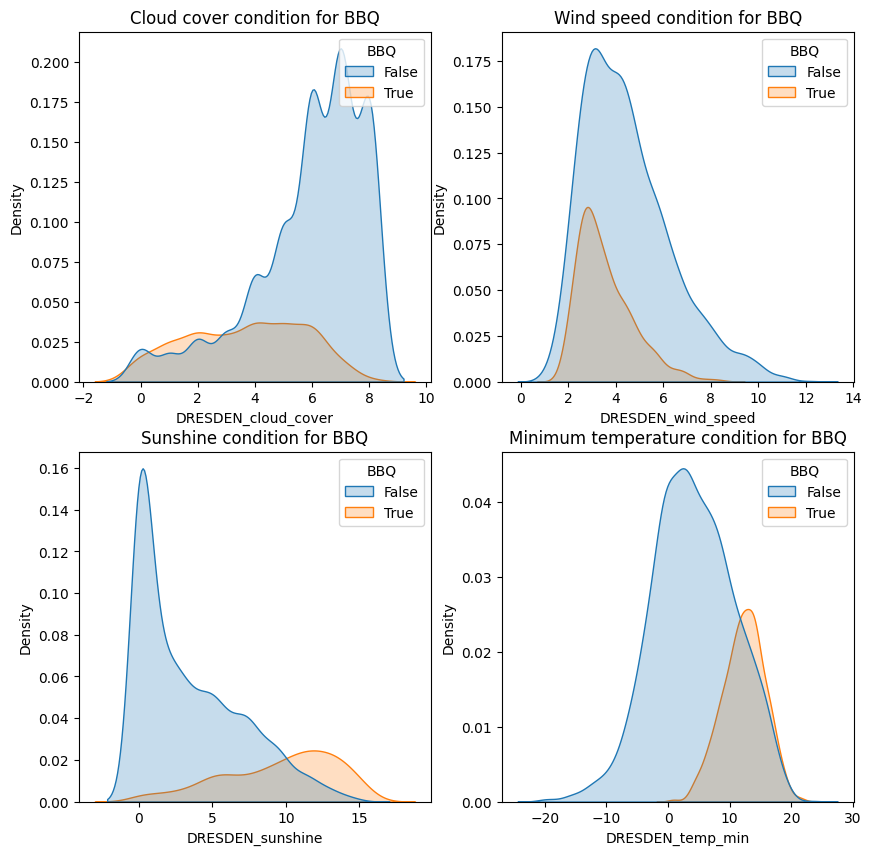

In [12]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.kdeplot(data = df_Dresden, x='DRESDEN_cloud_cover', hue = 'BBQ', fill = True, ax = axs[0,0])
axs[0,0].set_title('Cloud cover condition for BBQ')
sns.kdeplot(data = df_Dresden, x='DRESDEN_wind_speed', hue = 'BBQ', fill = True, ax = axs[0,1])
axs[0,1].set_title('Wind speed condition for BBQ')
sns.kdeplot(data = df_Dresden, x='DRESDEN_sunshine', hue = 'BBQ', fill = True, ax = axs[1,0])
axs[1,0].set_title('Sunshine condition for BBQ')
sns.kdeplot(data = df_Dresden, x='DRESDEN_temp_min', hue = 'BBQ', fill = True, ax = axs[1,1])
axs[1,1].set_title('Minimum temperature condition for BBQ')

plt.show()

/tmp/ipykernel_20/2075764383.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df_Dresden, x='DRESDEN_precipitation', hue = 'BBQ', fill = True, ax = axs[1,0])


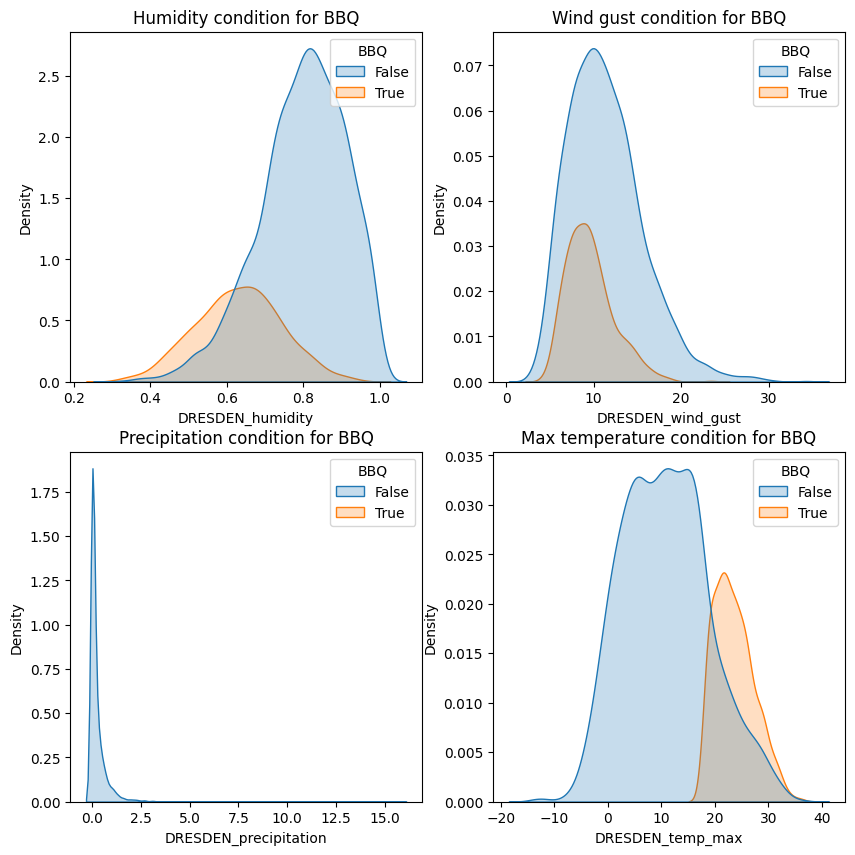

In [13]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.kdeplot(data = df_Dresden, x='DRESDEN_humidity', hue = 'BBQ', fill = True, ax = axs[0,0])
axs[0,0].set_title('Humidity condition for BBQ')

sns.kdeplot(data = df_Dresden, x='DRESDEN_wind_gust', hue = 'BBQ', fill = True, ax = axs[0,1])
axs[0,1].set_title('Wind gust condition for BBQ')

sns.kdeplot(data = df_Dresden, x='DRESDEN_precipitation', hue = 'BBQ', fill = True, ax = axs[1,0])
axs[1,0].set_title('Precipitation condition for BBQ')

sns.kdeplot(data = df_Dresden, x='DRESDEN_temp_max', hue = 'BBQ', fill = True, ax = axs[1,1])
axs[1,1].set_title('Max temperature condition for BBQ')

plt.show()

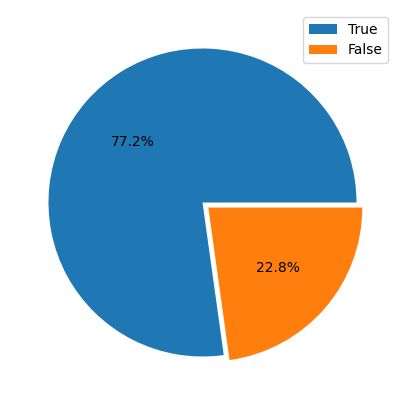

In [14]:
#True vs False: condition for having a nice weather
plt.figure(figsize = (5,5))
explode = [0,0.05]
plt.pie(df_Dresden['BBQ'].value_counts(), 
        explode=explode, autopct='%.1f%%');
plt.legend(['True', 'False']);
plt.show()

# Data preparation for model training

In [15]:
df_Dresden['BBQ'] = df_Dresden['BBQ'].map({True:1, False:0});

/tmp/ipykernel_20/2977729730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Dresden['BBQ'] = df_Dresden['BBQ'].map({True:1, False:0});


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [17]:
X = df_Dresden.drop(['DATE','BBQ'], axis = 1)
y = df_Dresden['BBQ']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 28)
len(X_train), len(X_test)

(2923, 731)

# ANN model building

In [18]:
#A very simple ANN model with 2 layers 
model = Sequential([
        Dense(X_train.shape[1], activation="relu"),
        Dense(X_train.shape[1]/2, activation="relu"),
        Dense(1, activation = 'sigmoid'),
    ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          validation_data=(X_test, y_test), verbose=0
          )

<Axes: >

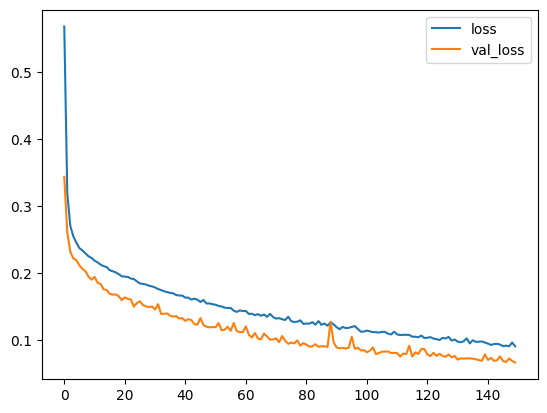

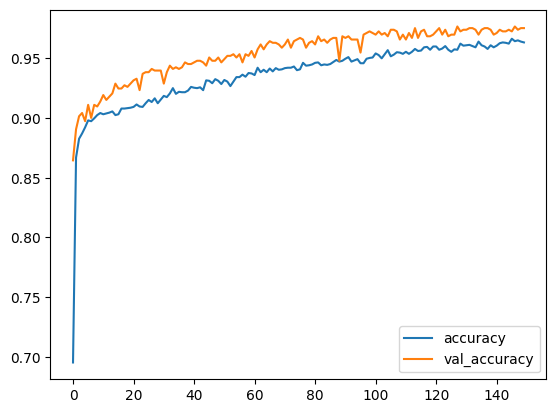

In [20]:
model_loss_acc = pd.DataFrame(model.history.history)
model_loss_acc[['loss', 'val_loss']].plot()
model_loss_acc[['accuracy', 'val_accuracy']].plot()

In [21]:
predictions = np.round(model.predict(X_test))
print(classification_report(y_test,predictions))

23/23 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       574
           1       0.93      0.96      0.94       157

    accuracy                           0.98       731
   macro avg       0.96      0.97      0.96       731
weighted avg       0.98      0.98      0.98       731



In [22]:
ann_acc = accuracy_score(y_test, predictions)
ann_acc

0.9753761969904241

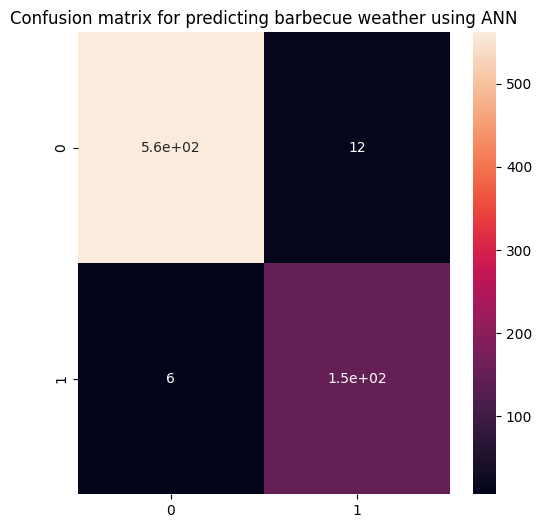

In [23]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot = True)
plt.title('Confusion matrix for predicting barbecue weather using ANN');

# CNN model building

In [24]:
from tensorflow.keras.layers import Conv1D, Flatten, Reshape

In [25]:
X_train.shape, X_test.shape

((2923, 10), (731, 10))

To use CNN with Conv1D layers, we need to reshape the input to have the form (batch_size, num_timesteps, num_features).

In [26]:
model_2 = Sequential(
    [Reshape((1,X_train.shape[1],1)),
     Conv1D(filters=10, kernel_size=2, activation='relu', 
            input_shape = (1,X_train.shape[1],1)),
     Flatten(),
     Dense(1, activation = 'sigmoid')
                     ])

In [27]:
model_2.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [28]:
model_2.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          validation_data=(X_test, y_test), verbose=0
          )

<Axes: >

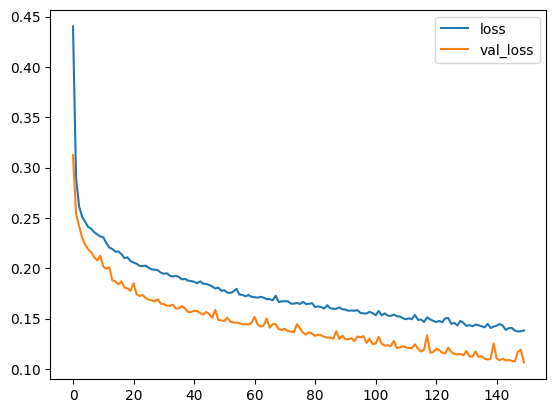

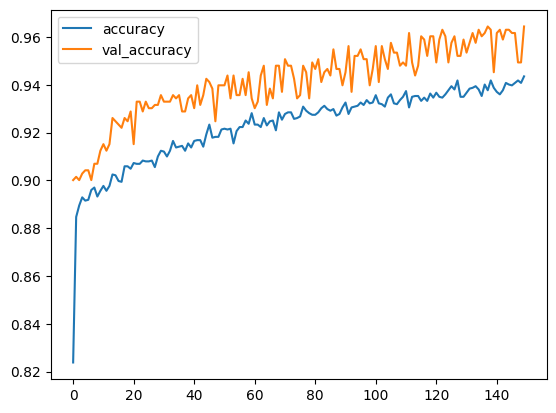

In [29]:
model2_loss_acc = pd.DataFrame(model_2.history.history)
model2_loss_acc[['loss', 'val_loss']].plot()
model2_loss_acc[['accuracy', 'val_accuracy']].plot()

In [30]:
pred_2 = np.round(model_2.predict(X_test))
print(classification_report(y_test,pred_2))

23/23 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       574
           1       0.91      0.93      0.92       157

    accuracy                           0.96       731
   macro avg       0.94      0.95      0.95       731
weighted avg       0.96      0.96      0.96       731



In [31]:
cnn_acc = accuracy_score(y_test, pred_2)
cnn_acc

0.9644322845417237

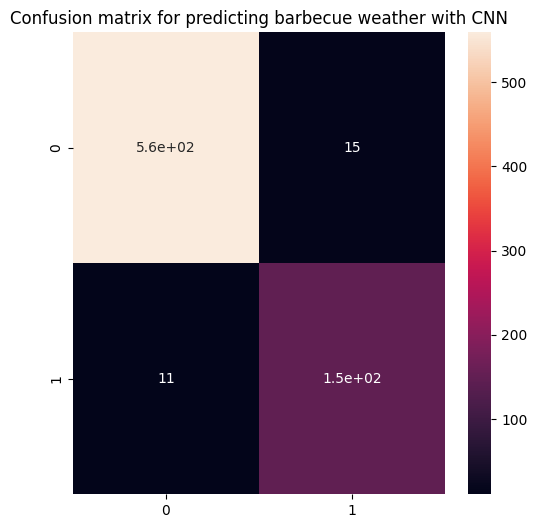

In [32]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, pred_2), annot=True)
plt.title('Confusion matrix for predicting barbecue weather with CNN');

# RandomForestClassifier

For code reference, see https://www.datacamp.com/tutorial/random-forests-classifier-python

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, pred_rf)
rf_acc

1.0

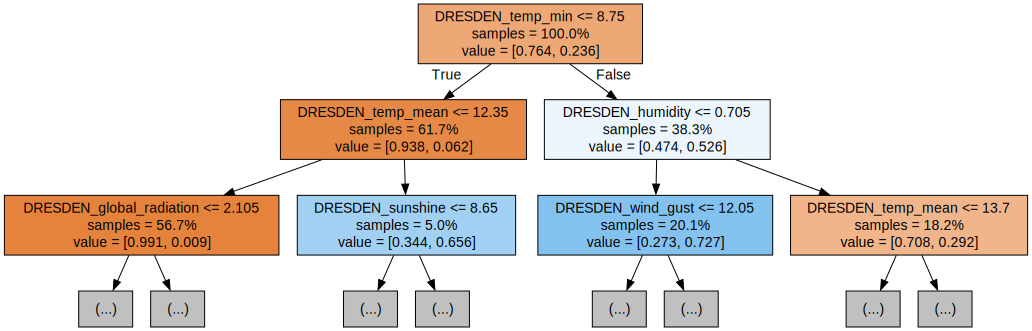

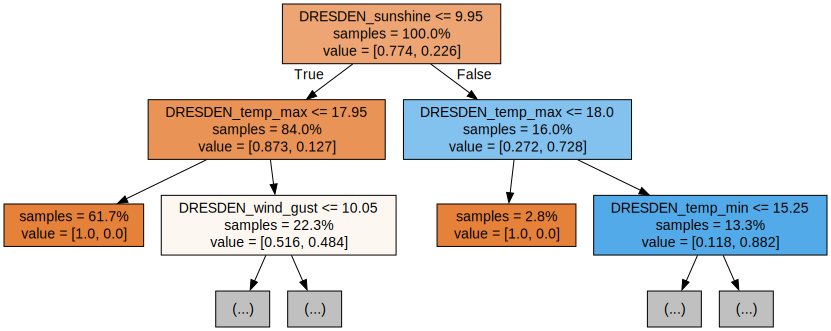

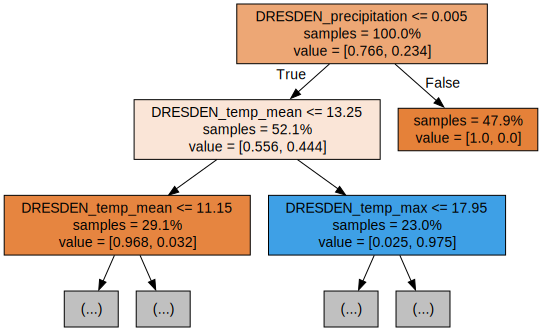

In [36]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

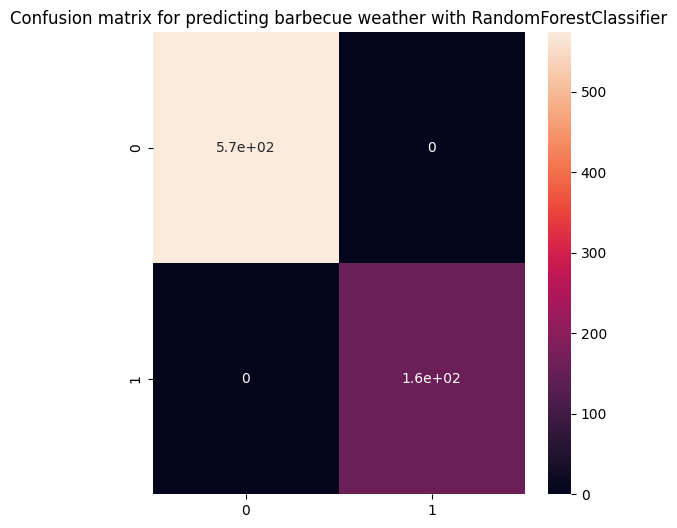

In [37]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True)
plt.title('Confusion matrix for predicting barbecue weather with RandomForestClassifier');

# ANN vs CNN vs RandomForestClassifier

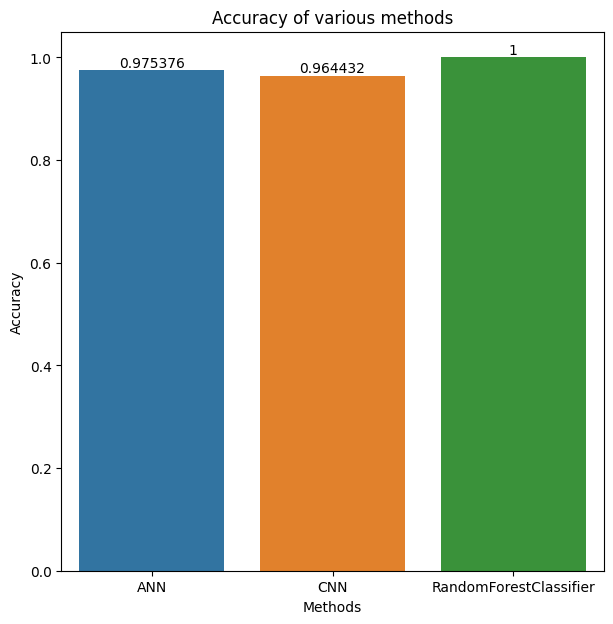

In [38]:
d = {'Methods': ['ANN', 'CNN', 'RandomForestClassifier'], 'Accuracy': [ann_acc, cnn_acc, rf_acc]}

dfc = pd.DataFrame(data=d)

plt.figure(figsize = (7,7))
ax = sns.barplot(x = 'Methods', y='Accuracy',
                 data=dfc,
                 errwidth=0);
ax.bar_label(ax.containers[0]);
plt.title('Accuracy of various methods');